In [1]:
#import os
import matplotlib.pyplot as plt
import numpy as np
import pybamm
import pandas as pd
import timeit
start = timeit.default_timer()
#os.chdir(pybamm.__path__[0]+'/..')
# pybamm.set_logging_level("INFO")

In [2]:
model = pybamm.lithium_ion.DFN(
    options={
        "particle": "Fickian diffusion", 
        #"SEI": "solvent-diffusion limited",
        #"SEI on cracks": "true",
        #"SEI film resistance": "distributed", 
        #"SEI porosity change": "true",
        #"particle mechanics": ("swelling and cracking", "swelling only"),
        "loss of active material": "stress-driven",
        #"lithium plating": "partially reversible"
    }
)

In [3]:
chemistry = pybamm.parameter_sets.OKane2022
param = pybamm.ParameterValues(chemistry=chemistry)
#param.update({"Ambient temperature [K]": 298.15})
param.update({"Upper voltage cut-off [V]": 4.21})
param.update({"Lower voltage cut-off [V]": 2.49})

In [4]:
total_cycles=10
exp = pybamm.Experiment(
    ["Hold at 4.2V until C/100", "Rest for 4 hours (5 minute period)", "Discharge at C/20 until 2.5V (5 minute period)",
    "Charge at 0.3C until 4.2 V (5 minute period)", "Hold at 4.2V until C/100 (5 minute period)"] + 
    [("Discharge at 1C until 2.5V", "Charge at 0.3C until 4.2V (5 minute period)", 
    "Hold at 4.2V until C/100 (5 minute period)",),] * total_cycles + ["Discharge at C/20 until 2.5V (5 minute period)"]
)

In [5]:
var_pts = {
    "x_n": 20,  # negative electrode
    "x_s": 20,  # separator 
    "x_p": 20,  # positive electrode
    "r_n": 30,  # negative particle
    "r_p": 30,  # positive particle
}

In [ ]:
# set mesh
submesh_types = model.default_submesh_types
particle_mesh = pybamm.MeshGenerator(pybamm.Exponential1DSubMesh, submesh_params={"side": "right", "stretch": 2.3})
submesh_types["negative particle"] = particle_mesh
submesh_types["positive particle"] = particle_mesh

In [ ]:
cycle_list = [
    3,4,14,24,34,44,54,64,74,84,94,104,114,124,134,144,154,164,174,184,194,204,214,224,234,244,254,264,274,284,294,
    304,314,324,334,344,354,364,374,384,394,404,414,424,434,444,454,464,474,484,494,504,514,524,534,544,554,564,574,584,594,
    604,614,624,634,644,654,664,674,684,694,704,714,724,734,744,754,764,774,784,794,804,814,824,834,844,854,864,874,884,894,
    904,914,924,934,944,954,964,974,984,994,1003,1004
]

In [6]:
sim1 = pybamm.Simulation(
    model, 
    experiment=exp,
    parameter_values=param,
    solver=pybamm.CasadiSolver(),
    var_pts=var_pts
)
solution1 = sim1.solve(calc_esoh=False)

stop = timeit.default_timer()
print('running time: ' + str(stop - start) +'s')

running time: 125.56623869999748s


In [7]:
path = '/mnt/c/Users/sokane/pybamm_data/OKane2022_verification/'

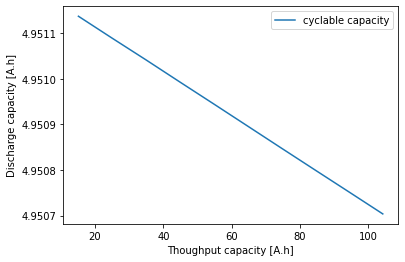

'\nM_cycles = np.array([Q_throughput,Qdis_cycles,Qsei,Qsei_cracks,Q_plating,\n                     cs_neg_avg,cs_neg_sep,cs_neg_CC,cs_pos_avg,cs_pos_sep,cs_pos_CC,\n                     U_neg_avg,U_neg_sep,U_neg_CC,U_pos_avg,U_pos_sep,U_pos_CC,\n                     AM_neg_avg,AM_neg_sep,AM_neg_CC,AM_pos_avg,AM_pos_sep,AM_pos_CC,\n                     porosity_avg,porosity_sep,porosity_CC,\n                     Lsei_avg,Lsei_sep,Lsei_CC,eta_SEI_avg,eta_SEI_sep,eta_SEI_CC,\n                     Lsei_cracks_avg,Lsei_cracks_sep,Lsei_cracks_CC,roughness_avg,roughness_sep,roughness_CC,\n                     c_plat_avg,c_plat_sep,c_plat_CC,c_dead_avg,c_dead_sep,c_dead_CC\n                     \n    ])\nfilename_cycles = path+\'FullyCoupled_reference_cycles.txt\'\nnp.savetxt(filename_cycles,M_cycles,delimiter=",")\n'

In [8]:
Q_previous = []
Q0 = solution1.cycles[0]["Discharge capacity [A.h]"].entries
Q0_delta = np.absolute(Q0[-1]-Q0[0])
Q2 = solution1.cycles[2]["Discharge capacity [A.h]"].entries
Q2_delta = np.absolute(Q2[-1]-Q2[0])
Q3 = solution1.cycles[3]["Discharge capacity [A.h]"].entries
Q3_delta = np.absolute(Q3[-1]-Q3[0])
Q4 = solution1.cycles[4]["Discharge capacity [A.h]"].entries
Q4_delta = np.absolute(Q4[-1]-Q4[0])
Q_previous.append(Q0_delta+Q2_delta+Q3_delta+Q4_delta)
Q_throughput = []
Qdis_cycles = []
"""
Qsei = []
Qsei_cracks = []
Q_plating = []
Q_LLI = []
total_Li = []
roughness_avg = []
roughness_sep = []
roughness_CC = []
porosity_avg = []
porosity_sep = []
porosity_CC = []
"""
cs_neg_avg = []
cs_neg_sep = []
cs_neg_CC = []
cs_pos_avg = []
cs_pos_sep = []
cs_pos_CC = []
U_neg_avg = []
U_neg_sep = []
U_neg_CC = []
U_pos_avg = []
U_pos_sep = []
U_pos_CC = []
"""
eta_SEI_avg = []
eta_SEI_sep = []
eta_SEI_CC = []
Lsei_avg = []
Lsei_sep = []
Lsei_CC = []
Lsei_cracks_avg = []
Lsei_cracks_sep = []
Lsei_cracks_CC = []
c_plat_avg = []
c_plat_sep = []
c_plat_CC = []
c_dead_avg = []
c_dead_sep = []
c_dead_CC = []
"""
AM_neg_avg = []
AM_neg_sep = []
AM_neg_CC = []
AM_pos_avg = []
AM_pos_sep = []
AM_pos_CC = []
for i in range(total_cycles):
    Qdis = solution1.cycles[i+5].steps[0]["Discharge capacity [A.h]"].entries
    Qdis_delta = Qdis[-1] - Qdis[0]
    Qdis_cycles.append(Qdis_delta)
    Q_throughput.append(Q_previous[i]+Qdis_delta)
    Q_CC = solution1.cycles[i+5].steps[1]["Discharge capacity [A.h]"].entries
    Q_CC_delta = np.absolute(Q_CC[-1]-Q_CC[0])
    Q_CV = solution1.cycles[i+5].steps[2]["Discharge capacity [A.h]"].entries
    Q_CV_delta = np.absolute(Q_CV[-1]-Q_CV[0])
    Q_previous.append(Q_previous[i]+Qdis_delta+Q_CC_delta+Q_CV_delta)
    """
    Qsei_loc=solution1.cycles[i+5].steps[0]["Loss of lithium to SEI [mol]"].entries
    Qsei.append(Qsei_loc[-1] * 96485.3/3600)  #[Ah]
    Qsei_cracks_loc=solution1.cycles[i+5].steps[0]["Loss of lithium to SEI on cracks [mol]"].entries
    Qsei_cracks.append(Qsei_cracks_loc[-1] * 96485.3/3600)  #[Ah]
    Q_pl_loc=solution1.cycles[i+5].steps[0]["Loss of lithium to lithium plating [mol]"].entries
    Q_plating.append(Q_pl_loc[-1] * 96485.3/3600)  #[Ah]
    Q_LLI.append((Qsei_loc[-1]+Q_pl_loc[-1]+Qsei_cracks_loc[-1]) * 96485.3/3600)  #[Ah]
    Li_total_neg_temp = solution1.cycles[i+5].steps[0]["Total lithium in negative electrode [mol]"].entries
    Li_total_pos_temp = solution1.cycles[i+5].steps[0]["Total lithium in positive electrode [mol]"].entries
    #Li_total_elec_temp = solution1.cycles[i+5].steps[0]["Total lithium in electrolyte [mol]"].entries
    total_Li.append(Li_total_neg_temp[-1]+Li_total_pos_temp[-1])
    roughness_avg_temp = solution1.cycles[i+5].steps[0]["X-averaged negative electrode roughness ratio"].entries
    roughness_avg.append(roughness_avg_temp[-1])
    roughness_sep_temp = solution1.cycles[i+5].steps[0]["Negative electrode roughness ratio"].entries[-1,-1]
    roughness_sep.append(roughness_sep_temp)
    roughness_CC_temp = solution1.cycles[i+5].steps[0]["Negative electrode roughness ratio"].entries[0,-1]
    roughness_CC.append(roughness_CC_temp)
    poro_avg_temp = solution1.cycles[i+5].steps[0]["X-averaged negative electrode porosity"].entries
    porosity_avg.append(poro_avg_temp[-1])
    poro_sep_temp = solution1.cycles[i+5].steps[0]["Negative electrode porosity"].entries[-1,-1]
    porosity_sep.append(poro_sep_temp)
    poro_CC_temp = solution1.cycles[i+5].steps[0]["Negative electrode porosity"].entries[0,-1]
    porosity_CC.append(poro_CC_temp)
    """
    cs_neg_avg_temp = solution1.cycles[i+5].steps[0]["X-averaged negative particle surface concentration"].entries
    cs_neg_avg.append(cs_neg_avg_temp[-1])
    cs_neg_sep_temp = solution1.cycles[i+5].steps[0]["Negative particle surface concentration"].entries[-1,-1]
    cs_neg_sep.append(cs_neg_sep_temp)
    cs_neg_CC_temp = solution1.cycles[i+5].steps[0]["Negative particle surface concentration"].entries[0,-1]
    cs_neg_CC.append(cs_neg_CC_temp)
    cs_pos_avg_temp = solution1.cycles[i+5].steps[0]["X-averaged positive particle surface concentration"].entries
    cs_pos_avg.append(cs_pos_avg_temp[-1])
    cs_pos_sep_temp = solution1.cycles[i+5].steps[0]["Positive particle surface concentration"].entries[0,-1]
    cs_pos_sep.append(cs_pos_sep_temp)
    cs_pos_CC_temp = solution1.cycles[i+5].steps[0]["Positive particle surface concentration"].entries[-1,-1]
    cs_pos_CC.append(cs_pos_CC_temp)
    U_neg_avg_temp = solution1.cycles[i+5].steps[0]["X-averaged negative electrode open circuit potential [V]"].entries
    U_neg_avg.append(U_neg_avg_temp[-1])
    U_neg_sep_temp = solution1.cycles[i+5].steps[0]["Negative electrode open circuit potential [V]"].entries[-1,-1]
    U_neg_sep.append(U_neg_sep_temp)
    U_neg_CC_temp = solution1.cycles[i+5].steps[0]["Negative electrode open circuit potential [V]"].entries[0,-1]
    U_neg_CC.append(U_neg_CC_temp)
    U_pos_avg_temp = solution1.cycles[i+5].steps[0]["X-averaged positive electrode open circuit potential [V]"].entries
    U_pos_avg.append(U_pos_avg_temp[-1])
    U_pos_sep_temp = solution1.cycles[i+5].steps[0]["Positive electrode open circuit potential [V]"].entries[0,-1]
    U_pos_sep.append(U_pos_sep_temp)
    U_pos_CC_temp = solution1.cycles[i+5].steps[0]["Positive electrode open circuit potential [V]"].entries[-1,-1]
    U_pos_CC.append(U_pos_CC_temp)
    """
    eta_SEI_temp = solution1.cycles[i+5].steps[0]["X-averaged SEI film overpotential [V]"].entries
    eta_SEI_avg.append(eta_SEI_temp[-1])
    eta_SEI_sep_temp = solution1.cycles[i+5].steps[0]["SEI film overpotential [V]"].entries[-1,-1]
    eta_SEI_sep.append(eta_SEI_sep_temp)
    eta_SEI_CC_temp = solution1.cycles[i+5].steps[0]["SEI film overpotential [V]"].entries[0,-1]
    eta_SEI_CC.append(eta_SEI_CC_temp)
    Lsei_temp = solution1.cycles[i+5].steps[0]["X-averaged total SEI thickness [m]"].entries
    Lsei_avg.append(Lsei_temp[-1])
    Lsei_sep_temp = solution1.cycles[i+5].steps[0]["Total SEI thickness [m]"].entries[-1,-1]
    Lsei_sep.append(Lsei_sep_temp)
    Lsei_CC_temp = solution1.cycles[i+5].steps[0]["Total SEI thickness [m]"].entries[0,-1]
    Lsei_CC.append(Lsei_CC_temp)
    Lcr_temp = solution1.cycles[i+5].steps[0]["X-averaged total SEI on cracks thickness [m]"].entries
    Lsei_cracks_avg.append(Lcr_temp[-1])
    Lcr_sep_temp = solution1.cycles[i+5].steps[0]["Total SEI on cracks thickness [m]"].entries[-1,-1]
    Lsei_cracks_sep.append(Lcr_sep_temp)
    Lcr_CC_temp = solution1.cycles[i+5].steps[0]["Total SEI on cracks thickness [m]"].entries[0,-1]
    Lsei_cracks_CC.append(Lcr_CC_temp)
    c_plat_avg_temp = solution1.cycles[i+5].steps[0]["X-averaged lithium plating concentration [mol.m-3]"].entries
    c_plat_avg.append(c_plat_avg_temp[-1])
    c_plat_sep_temp = solution1.cycles[i+5].steps[0]["Lithium plating concentration [mol.m-3]"].entries[-1,-1]
    c_plat_sep.append(c_plat_sep_temp)
    c_plat_CC_temp = solution1.cycles[i+5].steps[0]["Lithium plating concentration [mol.m-3]"].entries[0,-1]
    c_plat_CC.append(c_plat_CC_temp)
    c_dead_avg_temp = solution1.cycles[i+5].steps[0]["X-averaged dead lithium concentration [mol.m-3]"].entries
    c_dead_avg.append(c_dead_avg_temp[-1])
    c_dead_sep_temp = solution1.cycles[i+5].steps[0]["Dead lithium concentration [mol.m-3]"].entries[-1,-1]
    c_dead_sep.append(c_dead_sep_temp)
    c_dead_CC_temp = solution1.cycles[i+5].steps[0]["Dead lithium concentration [mol.m-3]"].entries[0,-1]
    c_dead_CC.append(c_dead_CC_temp)
    """
    AM_temp = solution1.cycles[i+5].steps[0]["X-averaged negative electrode active material volume fraction"].entries
    AM_neg_avg.append(AM_temp[-1])
    AM_sep_temp = solution1.cycles[i+5].steps[0]["Negative electrode active material volume fraction"].entries[-1,-1]
    AM_neg_sep.append(AM_sep_temp)
    AM_CC_temp = solution1.cycles[i+5].steps[0]["Negative electrode active material volume fraction"].entries[0,-1]
    AM_neg_CC.append(AM_CC_temp)
    AM_temp = solution1.cycles[i+5].steps[0]["X-averaged positive electrode active material volume fraction"].entries
    AM_pos_avg.append(AM_temp[-1])
    AM_sep_temp = solution1.cycles[i+5].steps[0]["Positive electrode active material volume fraction"].entries[0,-1]
    AM_pos_sep.append(AM_sep_temp)
    AM_CC_temp = solution1.cycles[i+5].steps[0]["Positive electrode active material volume fraction"].entries[-1,-1]
    AM_pos_CC.append(AM_CC_temp)
plt.figure()
plt.plot(Q_throughput, Qdis_cycles, label='cyclable capacity')
#plt.plot(Q_throughput, Qdis_cycles[0]-Qsei+Qsei[0], label="loss of Li to SEI", linestyle="dashdot")
#plt.plot(Q_throughput, Qdis_cycles[0]-Qsei_cracks+Qsei_cracks[0], label="loss of Li to SEI-cracks", linestyle="dashed")
#plt.plot(Q_throughput, Qdis_cycles[0]-Q_plating+Q_plating[0], label="loss of Li to plating", linestyle="dotted")
#plt.plot(Q_throughput, Qdis_cycles[0]-Q_LLI+Q_LLI[0], label="total loss of Li inventory")
plt.xlabel("Thoughput capacity [A.h]")
plt.ylabel("Discharge capacity [A.h]")
plt.legend()
filename = path+'FullyCoupled_reference.pdf'
#plt.savefig(filename,bbox_inches='tight')
plt.show()
"""
M_cycles = np.array([Q_throughput,Qdis_cycles,Qsei,Qsei_cracks,Q_plating,
                     cs_neg_avg,cs_neg_sep,cs_neg_CC,cs_pos_avg,cs_pos_sep,cs_pos_CC,
                     U_neg_avg,U_neg_sep,U_neg_CC,U_pos_avg,U_pos_sep,U_pos_CC,
                     AM_neg_avg,AM_neg_sep,AM_neg_CC,AM_pos_avg,AM_pos_sep,AM_pos_CC,
                     porosity_avg,porosity_sep,porosity_CC,
                     Lsei_avg,Lsei_sep,Lsei_CC,eta_SEI_avg,eta_SEI_sep,eta_SEI_CC,
                     Lsei_cracks_avg,Lsei_cracks_sep,Lsei_cracks_CC,roughness_avg,roughness_sep,roughness_CC,
                     c_plat_avg,c_plat_sep,c_plat_CC,c_dead_avg,c_dead_sep,c_dead_CC
                     
    ])
filename_cycles = path+'FullyCoupled_reference_cycles.txt'
np.savetxt(filename_cycles,M_cycles,delimiter=",")
"""

In [ ]:
plt.figure()
plt.plot(Q_throughput, total_Li)
plt.plot(Q_throughput, total_Li[0]-(Q_LLI-Q_LLI[0])*3600/96485.3, linestyle="dotted")
plt.show()

In [ ]:
Qdis1 = solution1.cycles[1].steps[0]["Discharge capacity [A.h]"].entries
Vdis1 = solution1.cycles[1].steps[0]["Terminal voltage [V]"].entries
Qdis10 = solution1.cycles[10].steps[0]["Discharge capacity [A.h]"].entries
Vdis10 = solution1.cycles[10].steps[0]["Terminal voltage [V]"].entries
fig, ax = plt.subplots()
ax.plot(Qdis1,Vdis1)
ax.plot(Qdis10,Vdis10)
ax.set_xlabel("Discharge capacity [A.h]")
ax.set_ylabel("Terminal voltage [V]")
plt.show()

In [ ]:
Q_CC1 = solution1.cycles[1].steps[1]["Discharge capacity [A.h]"].entries
V_CC1 = solution1.cycles[1].steps[1]["Terminal voltage [V]"].entries
Q_CC10 = solution1.cycles[10].steps[1]["Discharge capacity [A.h]"].entries
V_CC10 = solution1.cycles[10].steps[1]["Terminal voltage [V]"].entries
fig, ax = plt.subplots()
ax.plot(Q_CC1,V_CC1)
ax.plot(Q_CC10,V_CC10)
ax.set_xlabel("Discharge capacity [A.h]")
ax.set_ylabel("Terminal voltage [V]")
plt.show()

In [ ]:
t_CV1 = solution1.cycles[1].steps[2]["Time [h]"].entries
I_CV1 = solution1.cycles[1].steps[2]["Current [A]"].entries
Q_CV1 = solution1.cycles[1].steps[2]["Discharge capacity [A.h]"].entries
V_CV1 = solution1.cycles[1].steps[2]["Terminal voltage [V]"].entries
t_CV10 = solution1.cycles[10].steps[2]["Time [h]"].entries
I_CV10 = solution1.cycles[10].steps[2]["Current [A]"].entries
Q_CV10 = solution1.cycles[10].steps[2]["Discharge capacity [A.h]"].entries
V_CV10 = solution1.cycles[10].steps[2]["Terminal voltage [V]"].entries
fig, ax = plt.subplots()
ax.plot(Q_CV1,I_CV1)
ax.plot(Q_CV10,I_CV10)
ax.set_xlabel("Discharge capacity [A.h]")
ax.set_ylabel("Current [A]")
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot(t_CV1,V_CV1)
ax.plot(t_CV10,V_CV10)
ax.set_xlabel("Time [h]")
ax.set_ylabel("Terminal voltage [V]")
plt.show()

In [ ]:
plt.figure()
plt.plot(Q_throughput, AM_neg_avg)
plt.xlabel("Thoughput capacity [A.h]")
plt.ylabel("Negative active material fraction")
plt.show()

In [ ]:
 pybamm.Experiment([
    (f"Discharge at 1C until 2V",
     "Rest for 1 hour",
    )
]).operating_conditions_cycles

In [ ]:
exp.operating_conditions_cycles

In [ ]:
exp_test.operating_conditions_cycles

In [ ]:
exp_test = pybamm.Experiment(
    ["Hold at 4.2V until C/100","Rest for 4 hours (5 minute period)",] + [("Discharge at C/10 until 2.5V (5 minute period)", 
    "Charge at 0.3C until 4.2V (5 minute period)","Hold at 4.2V until C/100 (5 minute period)")] + [(
    "Discharge at 1C until 2.5V","Charge at 0.3C until 4.2V (5 minute period)","Hold at 4.2V until C/100 (5 minute period)",
    ),] * total_cycles + ["Discharge at C/10 until 2.5V (5 minute period)"]
)
pybamm.Simulation(
    model, 
    experiment=exp,
    parameter_values=param,
    solver=pybamm.CasadiSolver(),
    submesh_types = submesh_types,
).experiment.operating_conditions_cycles